In [11]:
using Revise
using Kinetic
using Flux
using DifferentialEquations
using DiffEqFlux
using Optim
using Plots

config = "../src/homogeneous/config.txt"
println("Reading settings from $config \n")

# generate parameters
D = read_dict(config)
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

dim = ifelse(parse(Int, space[3]) >= 3, 3, parse(Int, space[1]))
γ = 1.4#heat_capacity_ratio(inK, dim)
vSpace = VSpace1D(u0, u1, nu, vMeshType, nug)

f0 = Float32.(0.3 * vSpace.u.^2 .* exp.(-0.3 .* vSpace.u.^2)) |> Array
w0 = [ discrete_moments(f0, vSpace.u, vSpace.weights, 0), 
       discrete_moments(f0, vSpace.u, vSpace.weights, 1), 
       discrete_moments(f0, vSpace.u, vSpace.weights, 2) ]
prim0 = conserve_prim(w0, γ)

M = Float32.(maxwellian(vSpace.u, prim0)) |> Array

f = similar(M)

Reading settings from ../src/homogeneous/config.txt 

case = homogeneous
space = 1d1f
cfl = 0.5
maxTime = 10
u0 = -8
u1 = 8
nu = 101
vMeshType = newton
nug = 0
knudsen = 1
inK = 0



101-element Array{Float32,1}:
  2.2674865e-6 
 -8.097925e-7  
 -3.035457e-7  
 -5.6668614e-6 
 -3.4435575e-6 
 -8.7825896e-7 
  7.0658695e-7 
 -5.0284034e-6 
 -1.04676055e-5
 -7.846319e-6  
 -1.7956416e-5 
 -3.3294244e-5 
 -5.32318e-5   
  ⋮            
 -5.841771e-5  
 -2.111464e-5  
 -1.1368798e-5 
 -1.069967e-5  
 -3.362612e-6  
 -1.4193797e-5 
  8.148516e-7  
 -1.7605652e-6 
 -1.7602279e-6 
 -1.03273e-6   
  2.0776018e-7 
  6.1359237e-6 

In [13]:
function collision!(du, u, p, t)
    du .= p .- u
end

tspan = (0.0, maxTime)
tRange = range(tspan[1], tspan[2], length=3)
prob = ODEProblem(collision!, f0, tspan, M)
sol = solve(prob, Tsit5(), saveat=tRange)
ode_data = Array(sol)

101×3 Array{Float32,2}:
 1.26039e-7   7.07762e-8  7.04042e-8
 2.55067e-7   1.31853e-7  1.31023e-7
 5.08044e-7   2.42583e-7  2.40796e-7
 9.95938e-7   4.40758e-7  4.3702e-7 
 1.92146e-6   7.90868e-7  7.83256e-7
 3.6482e-6    1.40143e-6  1.3863e-6 
 6.81647e-6   2.45242e-6  2.42304e-6
 1.25329e-5   4.23814e-6  4.1823e-6 
 2.26743e-5   7.23282e-6  7.12886e-6
 4.03632e-5   1.21895e-5  1.19998e-5
 7.06936e-5   2.02865e-5  1.99472e-5
 0.000121813  3.33401e-5  3.27445e-5
 0.000206488  5.41076e-5  5.30817e-5
 ⋮                                  
 0.000121813  3.33401e-5  3.27445e-5
 7.06936e-5   2.02865e-5  1.99472e-5
 4.03632e-5   1.21895e-5  1.19998e-5
 2.26743e-5   7.23282e-6  7.12886e-6
 1.25329e-5   4.23814e-6  4.1823e-6 
 6.81647e-6   2.45242e-6  2.42304e-6
 3.6482e-6    1.40143e-6  1.3863e-6 
 1.92146e-6   7.90868e-7  7.83256e-7
 9.95938e-7   4.40758e-7  4.3702e-7 
 5.08044e-7   2.42583e-7  2.40796e-7
 2.55067e-7   1.31853e-7  1.31023e-7
 1.26039e-7   7.07762e-8  7.04042e-8

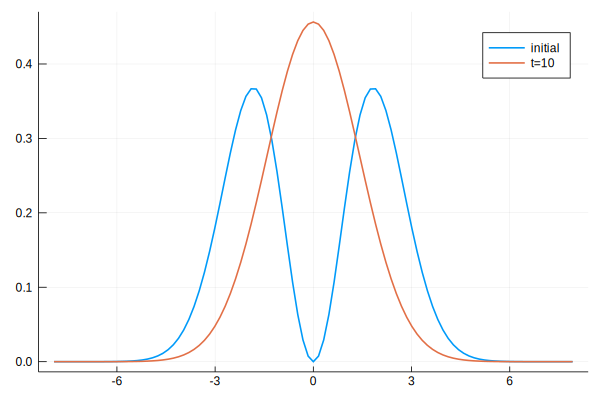

In [18]:
plot(vSpace.u, f0, lw=2, label="initial")
plot!(vSpace.u, sol.u[3], lw=2, label="t=10")

In [31]:
dudt = FastChain( (x, p) -> M,
                   FastDense(101,300,tanh),
                   FastDense(300,101) )
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat=tRange)

(::NeuralODE{FastChain{Tuple{var"#15#16",FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float64,Int64},Tsit5,Tuple{},Base.Iterators.Pairs{Symbol,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Tuple{Symbol},NamedTuple{(:saveat,),Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}}}) (generic function with 4 methods)

In [32]:
function predict_n_ode(u0, p)
    n_ode(u0, p)
end

function loss_n_ode(p)
    pred = predict_n_ode(f0, p)
    loss = sum(abs2, pred .- ode_data)
    return loss, pred
end

loss_n_ode(n_ode.p) # n_ode.p stores the initial parameters of the neural ODE

(251.43715f0, t: [0.0, 5.0, 10.0]
u: Array{Float32,1}[[1.2603898e-7, 2.5506657e-7, 5.080436e-7, 9.959375e-7, 1.9214565e-6, 3.648204e-6, 6.8164663e-6, 1.2532895e-5, 2.2674321e-5, 4.0363175e-5  …  4.0363175e-5, 2.2674321e-5, 1.2532895e-5, 6.8164663e-6, 3.648204e-6, 1.9214565e-6, 9.959375e-7, 5.080436e-7, 2.5506657e-7, 1.2603898e-7], [-0.275292, 0.6823822, -0.27018395, -0.03763207, 1.4880724, 0.23210685, -0.22373445, -0.0058199074, -0.27902493, -0.33235148  …  -0.14867248, -0.63681304, 0.7775352, 0.6477919, -0.65064037, 0.11195636, 1.3341708, -0.16982467, -0.26486918, 1.0713651], [-0.55058414, 1.3647642, -0.5403684, -0.07526514, 2.976143, 0.46421006, -0.44747573, -0.011652348, -0.5580725, -0.66474336  …  -0.2973853, -1.2736487, 1.5550578, 1.2955769, -1.3012844, 0.2239108, 2.6683407, -0.33964986, -0.5297386, 2.1427302]])

(251.43715f0, t: [0.0, 5.0, 10.0]
u: Array{Float32,1}[[1.2603898e-7, 2.5506657e-7, 5.080436e-7, 9.959375e-7, 1.9214565e-6, 3.648204e-6, 6.8164663e-6, 1.2532895e-5, 2.2674321e-5, 4.0363175e-5  …  4.0363175e-5, 2.2674321e-5, 1.2532895e-5, 6.8164663e-6, 3.648204e-6, 1.9214565e-6, 9.959375e-7, 5.080436e-7, 2.5506657e-7, 1.2603898e-7], [-0.275292, 0.6823822, -0.27018395, -0.03763207, 1.4880724, 0.23210685, -0.22373445, -0.0058199074, -0.27902493, -0.33235148  …  -0.14867248, -0.63681304, 0.7775352, 0.6477919, -0.65064037, 0.11195636, 1.3341708, -0.16982467, -0.26486918, 1.0713651], [-0.55058414, 1.3647642, -0.5403684, -0.07526514, 2.976143, 0.46421006, -0.44747573, -0.011652348, -0.5580725, -0.66474336  …  -0.2973853, -1.2736487, 1.5550578, 1.2955769, -1.3012844, 0.2239108, 2.6683407, -0.33964986, -0.5297386, 2.1427302]])

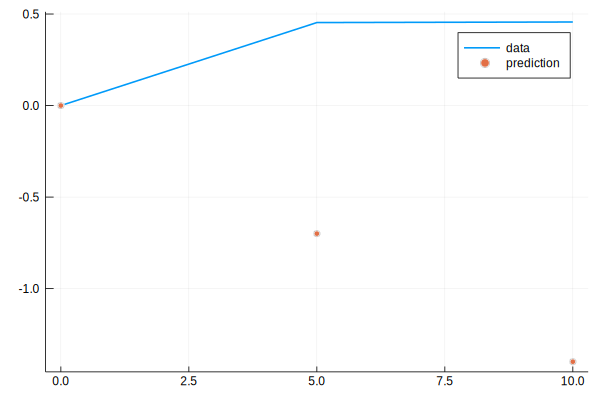

false

In [33]:
cb = function (p,l,pred;doplot=false) #callback function to observe training
    display(l)
    # plot current prediction against data
    if doplot
        pl = plot(tRange, ode_data[51,:], lw=2, label="data")
        scatter!(pl, tRange, pred[51,:], label="prediction")
        display(plot(pl))
    end
    return false
end

# Display the ODE with the initial parameter values.
cb(n_ode.p, loss_n_ode(n_ode.p), predict_n_ode(f0, n_ode.p), doplot=true)

In [34]:
res = DiffEqFlux.sciml_train(loss_n_ode, n_ode.p, ADAM(), cb=cb, maxiters=200)

251.43694f0

loss: 251:   0%|▎                                        |  ETA: 0:20:07

123.797775f0

loss: 124:   1%|▍                                        |  ETA: 0:10:16

50.598495f0

loss: 50.6:   2%|▋                                        |  ETA: 0:06:58

17.602804f0

loss: 17.6:   2%|▉                                        |  ETA: 0:05:19

10.669491f0

loss: 10.7:   2%|█                                        |  ETA: 0:04:18

17.2928f0

loss: 17.3:   3%|█▎                                       |  ETA: 0:03:38

27.05941f0

33.390144f0

loss: 33.4:   4%|█▋                                       |  ETA: 0:02:47

34.336353f0

loss: 34.3:   4%|█▉                                       |  ETA: 0:02:30

31.002834f0

loss: 31:   5%|██                                       |  ETA: 0:02:16

25.400793f0

loss: 25.4:   6%|██▎                                      |  ETA: 0:02:05

19.283905f0

loss: 19.3:   6%|██▌                                      |  ETA: 0:01:56

13.835677f0

loss: 13.8:   6%|██▋                                      |  ETA: 0:01:48

9.645096f0

loss: 9.65:   7%|██▉                                      |  ETA: 0:01:41

6.833113f0

5.250395f0

loss: 5.25:   8%|███▎                                     |  ETA: 0:01:30

4.632035f0

loss: 4.63:   8%|███▌                                     |  ETA: 0:01:26

4.6771836f0

5.0862694f0

loss: 5.09:  10%|███▉                                     |  ETA: 0:01:18

5.5946503f0

loss: 5.59:  10%|████▏                                    |  ETA: 0:01:14

6.007009f0

6.2113957f0

loss: 6.21:  11%|████▌                                    |  ETA: 0:01:09

6.166983f0

5.8802557f0

loss: 5.88:  12%|████▉                                    |  ETA: 0:01:04

5.383498f0

loss: 5.38:  12%|█████▏                                   |  ETA: 0:01:01

4.724771f0

loss: 4.72:  13%|█████▍                                   |  ETA: 0:00:59

3.9677792f0

loss: 3.97:  14%|█████▌                                   |  ETA: 0:00:58

3.1901338f0

2.4720142f0

loss: 2.47:  14%|██████                                   |  ETA: 0:00:54

1.8792422f0

1.4508702f0

loss: 1.45:  16%|██████▍                                  |  ETA: 0:00:51

1.197247f0

1.1055987f0

loss: 1.11:  16%|██████▊                                  |  ETA: 0:00:48

1.1461327f0

1.2755762f0

loss: 1.28:  18%|███████▏                                 |  ETA: 0:00:46

1.4412099f0

1.5888056f0

loss: 1.59:  18%|███████▋                                 |  ETA: 0:00:44

1.6734314f0

1.6690272f0

loss: 1.67:  20%|████████                                 |  ETA: 0:00:42

1.573276f0

1.4061809f0

loss: 1.41:  20%|████████▍                                |  ETA: 0:00:40

1.202186f0

loss: 1.2:  21%|████████▋                                |  ETA: 0:00:39

0.9982126f0

0.8228416f0

loss: 0.823:  22%|█████████                                |  ETA: 0:00:38

0.69159997f0

0.6087305f0

loss: 0.609:  23%|█████████▍                               |  ETA: 0:00:36

0.57142496f0

0.57260394f0

loss: 0.573:  24%|█████████▉                               |  ETA: 0:00:35

0.6017303f0

0.6454589f0

loss: 0.645:  25%|██████████▎                              |  ETA: 0:00:33

0.689391f0

0.72066706f0

loss: 0.721:  26%|██████████▋                              |  ETA: 0:00:32

0.7305766f0

0.71642196f0

loss: 0.716:  27%|███████████▏                             |  ETA: 0:00:31

0.68182087f0

0.6348835f0

loss: 0.635:  28%|███████████▌                             |  ETA: 0:00:30

0.5848997f0

0.5393873f0

loss: 0.539:  29%|███████████▉                             |  ETA: 0:00:29

0.5030058f0

0.47815555f0

loss: 0.478:  30%|████████████▎                            |  ETA: 0:00:28

0.4657851f0

0.46532422f0

loss: 0.465:  31%|████████████▊                            |  ETA: 0:00:27

0.474124f0

0.48761675f0

loss: 0.488:  32%|█████████████▏                           |  ETA: 0:00:26

0.5006792f0

0.50931966f0

loss: 0.509:  33%|█████████████▌                           |  ETA: 0:00:25

0.511499f0

0.5069269f0

loss: 0.507:  34%|██████████████                           |  ETA: 0:00:24

0.49662593f0

0.482744f0

loss: 0.483:  35%|██████████████▍                          |  ETA: 0:00:24

0.46823296f0

0.4559966f0

loss: 0.456:  36%|██████████████▊                          |  ETA: 0:00:23

0.44790643f0

loss: 0.448:  36%|███████████████                          |  ETA: 0:00:23

0.44440007f0

0.44477206f0

loss: 0.445:  38%|███████████████▍                         |  ETA: 0:00:22

0.4476838f0

0.45155612f0

loss: 0.452:  38%|███████████████▊                         |  ETA: 0:00:21

0.45491433f0

0.4567534f0

loss: 0.457:  40%|████████████████▎                        |  ETA: 0:00:21

0.45673314f0

0.4550613f0

loss: 0.455:  40%|████████████████▋                        |  ETA: 0:00:20

0.45221913f0

0.44879448f0

loss: 0.449:  42%|█████████████████                        |  ETA: 0:00:20

0.44543532f0

0.44274354f0

loss: 0.443:  42%|█████████████████▍                       |  ETA: 0:00:19

0.44106275f0

0.44036615f0

loss: 0.44:  44%|█████████████████▉                       |  ETA: 0:00:19

0.44038567f0

0.44083622f0

loss: 0.441:  44%|██████████████████▎                      |  ETA: 0:00:18

0.4414981f0

0.44215623f0

loss: 0.442:  46%|██████████████████▋                      |  ETA: 0:00:18

0.44257373f0

0.4425765f0

loss: 0.443:  46%|███████████████████▏                     |  ETA: 0:00:17

0.44214013f0

0.44138667f0

loss: 0.441:  48%|███████████████████▌                     |  ETA: 0:00:17

0.44050783f0

0.43968356f0

loss: 0.44:  48%|███████████████████▉                     |  ETA: 0:00:16

0.43903708f0

0.4386256f0

loss: 0.439:  50%|████████████████████▎                    |  ETA: 0:00:16

0.43845823f0

0.43849936f0

loss: 0.438:  50%|████████████████████▊                    |  ETA: 0:00:15

0.4386717f0

0.43887848f0

loss: 0.439:  52%|█████████████████████▏                   |  ETA: 0:00:15

0.4390374f0

0.43910015f0

loss: 0.439:  52%|█████████████████████▌                   |  ETA: 0:00:14

0.43904954f0

0.43889472f0

loss: 0.439:  54%|█████████████████████▉                   |  ETA: 0:00:14

0.4386654f0

0.4384039f0

loss: 0.438:  54%|██████████████████████▍                  |  ETA: 0:00:14

0.43815875f0

0.4379784f0

loss: 0.438:  56%|██████████████████████▊                  |  ETA: 0:00:13

0.4378999f0

0.43792197f0

loss: 0.438:  56%|███████████████████████▏                 |  ETA: 0:00:13

0.43800738f0

0.43810406f0

loss: 0.438:  58%|███████████████████████▋                 |  ETA: 0:00:12

0.43816817f0

0.43818277f0

loss: 0.438:  58%|████████████████████████                 |  ETA: 0:00:12

0.43814987f0

0.4380834f0

loss: 0.438:  60%|████████████████████████▍                |  ETA: 0:00:12

0.4379992f0

0.4379163f0

loss: 0.438:  60%|████████████████████████▊                |  ETA: 0:00:11

0.4378508f0

0.4378113f0

loss: 0.438:  62%|█████████████████████████▎               |  ETA: 0:00:11

0.43780142f0

0.4378152f0

loss: 0.438:  62%|█████████████████████████▋               |  ETA: 0:00:11

0.43784493f0

0.43787438f0

loss: 0.438:  64%|██████████████████████████               |  ETA: 0:00:10

0.43789175f0

0.43789047f0

loss: 0.438:  64%|██████████████████████████▌              |  ETA: 0:00:10

0.4378701f0

0.43784037f0

loss: 0.438:  66%|██████████████████████████▉              |  ETA: 0:00:10

0.43781087f0

0.43778786f0

loss: 0.438:  66%|███████████████████████████▎             |  ETA: 0:00:09

0.43777505f0

0.43777362f0

loss: 0.438:  68%|███████████████████████████▋             |  ETA: 0:00:09

0.43777853f0

0.4377859f0

loss: 0.438:  68%|████████████████████████████▏            |  ETA: 0:00:09

0.43779388f0

0.4377973f0

loss: 0.438:  70%|████████████████████████████▌            |  ETA: 0:00:08

0.43779647f0

0.4377921f0

loss: 0.438:  70%|████████████████████████████▉            |  ETA: 0:00:08

0.4377838f0

0.4377762f0

loss: 0.438:  72%|█████████████████████████████▍           |  ETA: 0:00:08

0.43776894f0

loss: 0.438:  72%|█████████████████████████████▌           |  ETA: 0:00:08

0.4377654f0

0.4377641f0

loss: 0.438:  73%|█████████████████████████████▉           |  ETA: 0:00:07

0.43776405f0

0.4377658f0

loss: 0.438:  74%|██████████████████████████████▍          |  ETA: 0:00:07

0.43776837f0

0.43776914f0

loss: 0.438:  75%|██████████████████████████████▊          |  ETA: 0:00:07

0.4377699f0

0.43776828f0

loss: 0.438:  76%|███████████████████████████████▏         |  ETA: 0:00:06

0.43776605f0

0.4377635f0

loss: 0.438:  77%|███████████████████████████████▋         |  ETA: 0:00:06

0.43776193f0

0.4377604f0

loss: 0.438:  78%|████████████████████████████████         |  ETA: 0:00:06

0.43775913f0

0.43775928f0

loss: 0.438:  79%|████████████████████████████████▍        |  ETA: 0:00:06

0.4377605f0

0.4377612f0

loss: 0.438:  80%|████████████████████████████████▊        |  ETA: 0:00:05

0.43776175f0

0.43776128f0

loss: 0.438:  81%|█████████████████████████████████▎       |  ETA: 0:00:05

0.43776143f0

0.43776014f0

loss: 0.438:  82%|█████████████████████████████████▋       |  ETA: 0:00:05

0.43775922f0

0.43775845f0

loss: 0.438:  83%|██████████████████████████████████       |  ETA: 0:00:04

0.4377579f0

0.43775773f0

loss: 0.438:  84%|██████████████████████████████████▌      |  ETA: 0:00:04

0.4377579f0

0.43775812f0

loss: 0.438:  85%|██████████████████████████████████▉      |  ETA: 0:00:04

0.4377585f0

0.43775937f0

loss: 0.438:  86%|███████████████████████████████████▎     |  ETA: 0:00:04

0.4377587f0

0.43775904f0

loss: 0.438:  87%|███████████████████████████████████▋     |  ETA: 0:00:03

0.43775806f0

0.43775767f0

loss: 0.438:  88%|████████████████████████████████████▏    |  ETA: 0:00:03

0.43775743f0

0.437758f0

loss: 0.438:  89%|████████████████████████████████████▌    |  ETA: 0:00:03

0.43775746f0

0.4377582f0

loss: 0.438:  90%|████████████████████████████████████▉    |  ETA: 0:00:03

0.43775773f0

loss: 0.438:  90%|█████████████████████████████████████▏   |  ETA: 0:00:02

0.43775773f0

0.43775773f0

loss: 0.438:  92%|█████████████████████████████████████▌   |  ETA: 0:00:02

0.43775764f0

0.43775755f0

loss: 0.438:  92%|█████████████████████████████████████▉   |  ETA: 0:00:02

0.437758f0

0.4377574f0

loss: 0.438:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

0.43775797f0

0.4377579f0

loss: 0.438:  94%|██████████████████████████████████████▊  |  ETA: 0:00:01

0.43775797f0

0.43775743f0

loss: 0.438:  96%|███████████████████████████████████████▏ |  ETA: 0:00:01

0.43775743f0

0.43775746f0

loss: 0.438:  96%|███████████████████████████████████████▋ |  ETA: 0:00:01

0.43775803f0

loss: 0.438:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

0.4377574f0

0.43775734f0

loss: 0.438:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

0.4377573f0

0.4377578f0

loss: 0.438:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

0.43775794f0

0.43775797f0

loss: 0.438: 100%|█████████████████████████████████████████| Time: 0:00:24


0.4377573f0

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-9.76e-02, -1.39e-02, 9.88e-02,  ...]
    Minimum:   4.377580e-01

 * Found with
    Algorithm:     ADAM
    Initial Point: [-9.17e-02, -6.27e-03, 9.69e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


0.43775803f0

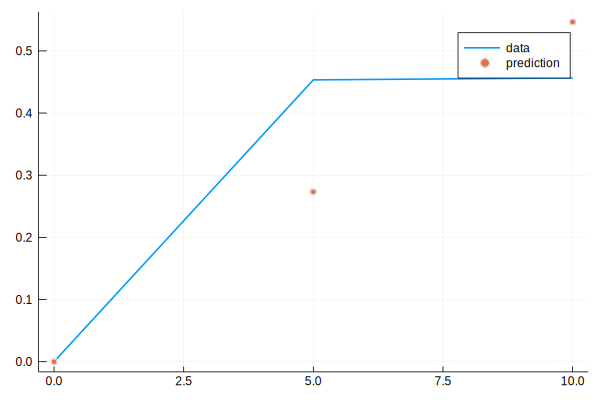

false

In [35]:
cb(res.minimizer,loss_n_ode(res.minimizer)...;doplot=true)

In [42]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, LBFGS(), cb=cb, maxiters=200)

ReadOnlyMemoryError: ReadOnlyMemoryError()

58.083244f0

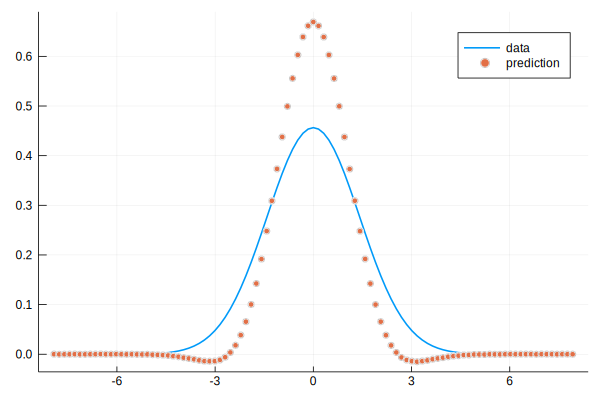

false

In [109]:
cb(res.minimizer, loss_n_ode(res.minimizer)...; doplot=true)

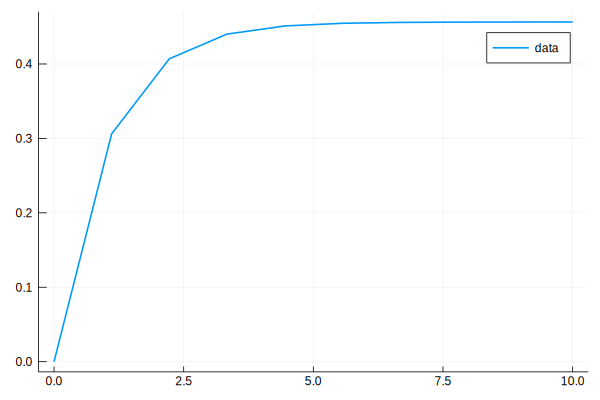

In [209]:
plot(tRange, ode_data[51,:], lw=2, label="data")

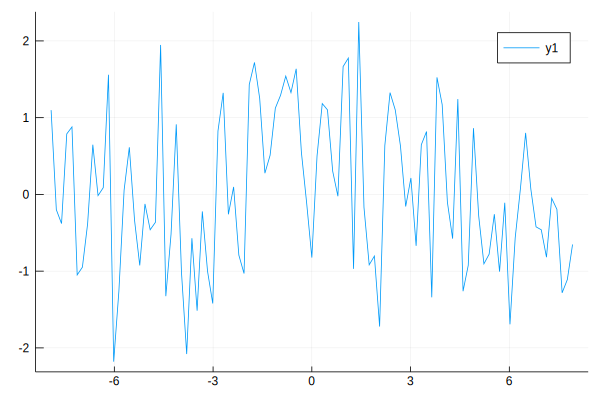

In [30]:
plot(vSpace.u, predict_n_ode(f0, res.minimizer).u[2])

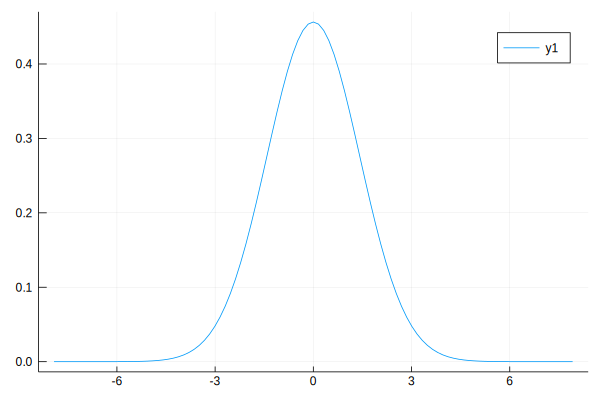

In [247]:
plot(vSpace.u, ode_data[:,5])